**Overview**: This Projet seeks to create a model that can be used to predict Life Expectancy based on select features that have been demonstrated to show a corelation with Long Life.


### Understanding the Data

This Project is based on the Global Health Observatory (GHO) data repository under World Health Organization (WHO).  It keeps track of the health status for serveral countries for the purpose of health data analysis.  Considered data is from year 2000-2015 for 193 countries.

In [654]:
import pandas as pd
import time
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt
from category_encoders import BinaryEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
from sklearn.utils import shuffle
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor


# set style of visualization
sns.set_style("whitegrid")
sns.set_palette("RdBu")

In [473]:
life = pd.read_csv('data/data.csv')
life = shuffle(life)


In [628]:
!pip install scikeras

In [475]:
life.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
1241,Iraq,2008,Developing,69.3,167.0,32,0.17,192.156300,66.0,5494,...,71.0,3.93,69.0,0.1,4521.3247,29111417.0,5.4,5.1,0.638,10.3
1257,Ireland,2008,Developed,79.8,75.0,0,12.66,9528.230574,NaN,57,...,93.0,8.64,93.0,0.1,61235.4150,4489544.0,0.3,0.2,0.908,17.9
916,Finland,2013,Developing,87.0,79.0,0,8.97,6115.496624,NaN,2,...,98.0,9.55,98.0,0.1,49638.7713,5438972.0,0.9,0.8,0.887,17.0
974,Gambia,2003,Developing,57.0,297.0,3,2.47,0.000000,94.0,119,...,87.0,4.22,87.0,2.7,NaN,NaN,9.6,9.6,0.395,7.3
2418,South Sudan,2006,Developing,52.5,383.0,28,NaN,0.000000,NaN,0,...,NaN,NaN,NaN,4.1,NaN,8468152.0,NaN,NaN,0.000,0.0


### Understanding the Features

Data is examined to determine if any of the features are missing values or need to be coerced to a different data type.

In [478]:
features = pd.DataFrame(life[["Status", "Life expectancy ","Adult Mortality","infant deaths", "Alcohol","percentage expenditure","Hepatitis B","Measles "," BMI ","under-five deaths ", " thinness 5-9 years", "Polio","Total expenditure","Diphtheria "," HIV/AIDS","GDP"," thinness  1-19 years","Income composition of resources","Schooling"]]) 		

In [480]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2938 entries, 1241 to 315
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Status                           2938 non-null   object 
 1   Life expectancy                  2928 non-null   float64
 2   Adult Mortality                  2928 non-null   float64
 3   infant deaths                    2938 non-null   int64  
 4   Alcohol                          2744 non-null   float64
 5   percentage expenditure           2938 non-null   float64
 6   Hepatitis B                      2385 non-null   float64
 7   Measles                          2938 non-null   int64  
 8    BMI                             2904 non-null   float64
 9   under-five deaths                2938 non-null   int64  
 10   thinness 5-9 years              2904 non-null   float64
 11  Polio                            2919 non-null   float64
 12  Total expenditure      

In [482]:
features.isnull().sum()

Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
 thinness 5-9 years                 34
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
 thinness  1-19 years               34
Income composition of resources    167
Schooling                          163
dtype: int64

In [484]:
len(features)

2938

In [486]:
features = features.fillna(features.median(numeric_only = True))

In [488]:
features.isnull().sum()

Status                             0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
 BMI                               0
under-five deaths                  0
 thinness 5-9 years                0
Polio                              0
Total expenditure                  0
Diphtheria                         0
 HIV/AIDS                          0
GDP                                0
 thinness  1-19 years              0
Income composition of resources    0
Schooling                          0
dtype: int64

### Business Objective


<b>Answer:</b>The business objective is to analyze the dataset of health data and its features to determine what features can be used to create the most optimal 
prediction model for predicting how long a person will live.  In addition to determining the most critical features, the business objective is 
to determine what model performs the best based on training time and accuracy score.

### Engineering Features

Data is Encoded to make it more numerical

In [493]:
result = features[["Life expectancy "]]

In [495]:
features.drop("Life expectancy ", axis=1, inplace=True)


In [497]:
col_transformer = make_column_transformer((OrdinalEncoder(categories = [['Developing','Developed']]), ['Status']), remainder='passthrough')

### Train/Test Split

Data is split into a train and test set.

In [500]:
X_train, X_test, y_train, y_test = train_test_split(features,result,test_size = 0.3, random_state = 22)

In [502]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2056 entries, 213 to 2503
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Status                           2056 non-null   object 
 1   Adult Mortality                  2056 non-null   float64
 2   infant deaths                    2056 non-null   int64  
 3   Alcohol                          2056 non-null   float64
 4   percentage expenditure           2056 non-null   float64
 5   Hepatitis B                      2056 non-null   float64
 6   Measles                          2056 non-null   int64  
 7    BMI                             2056 non-null   float64
 8   under-five deaths                2056 non-null   int64  
 9    thinness 5-9 years              2056 non-null   float64
 10  Polio                            2056 non-null   float64
 11  Total expenditure                2056 non-null   float64
 12  Diphtheria             

In [504]:
X_train.head()

,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,thinness 5-9 years,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,thinness 1-19 years,Income composition of resources,Schooling
213,Developing,16.0,0,8.41,154.963086,86.0,0,5.7,0,3.8,9.0,6.17,86.0,0.1,1595.912320,3.8,0.781,15.8
2518,Developed,71.0,0,6.90,3998.099870,92.0,9,53.9,0,1.3,99.0,9.23,99.0,0.1,29571.744600,1.3,0.880,15.9
2850,Developing,157.0,0,1.01,342.490856,6.0,0,46.6,0,1.5,67.0,3.67,67.0,0.1,2393.367265,1.6,0.579,10.7
2089,Developing,68.0,1,9.33,0.000000,99.0,107,3.8,2,1.0,99.0,7.20,99.0,0.1,1766.947595,1.5,0.677,12.3
2438,Developed,83.0,2,12.26,228.354302,82.0,67,58.8,2,0.5,98.0,7.25,98.0,0.1,1719.535410,0.6,0.828,15.7


### Baseline Model

The Baselne Model is a simple LinearRegression Model

In [507]:
baseline = Pipeline([("col_transformer", col_transformer), ('linreg', LinearRegression())])

In [509]:
baseline = baseline.fit(X_train, y_train) 

In [511]:
preds = baseline.predict(X_test)

In [513]:
mse_base = mean_squared_error(y_test, preds)

In [515]:
print(mse_base)

17.69594815802429


In [517]:
baseline.score(X_train,y_train)

0.8238056905277186

### A Simple Model

A Ridge Model is used as the first model to be tested against the baseline

In [521]:
train_score = [0, 0, 0,0,0]
test_score = [0, 0, 0,0,0]
average_fit_time = [0, 0, 0,0,0]

In [523]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2056 entries, 213 to 2503
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Status                           2056 non-null   object 
 1   Adult Mortality                  2056 non-null   float64
 2   infant deaths                    2056 non-null   int64  
 3   Alcohol                          2056 non-null   float64
 4   percentage expenditure           2056 non-null   float64
 5   Hepatitis B                      2056 non-null   float64
 6   Measles                          2056 non-null   int64  
 7    BMI                             2056 non-null   float64
 8   under-five deaths                2056 non-null   int64  
 9    thinness 5-9 years              2056 non-null   float64
 10  Polio                            2056 non-null   float64
 11  Total expenditure                2056 non-null   float64
 12  Diphtheria             

In [525]:
ridge = Pipeline([("col_transformer", col_transformer),("scalar",StandardScaler()),('ridge', Ridge(random_state=22))])

In [527]:
start_time = time.time()
ridge.fit(X_train, y_train)
end_time = time.time()
preds = ridge.predict(X_test)

fit_time_log_reg = end_time - start_time
average_fit_time[0] = fit_time_log_reg


In [529]:
mse_ridge = mean_squared_error(y_test, preds)

In [531]:
print(mse_ridge)

17.699271743835425


Score the Model

In [534]:
ridge_acc_train = ridge.score(X_train,y_train)
ridge_acc_test = ridge.score(X_test,y_test)
train_score[0] = ridge_acc_train
test_score[0] =  ridge_acc_test

### Model Comparisons

In [537]:
lasso = Pipeline([("col_transformer", col_transformer),("scalar",StandardScaler()),('lasso', Lasso(alpha=0.1))])

In [539]:
# Fit the model to the training data
start_time = time.time()
lasso.fit(X_train, y_train)
end_time = time.time()
fit_time_lasso = end_time - start_time
average_fit_time[1] = fit_time_lasso

In [541]:
preds = lasso.predict(X_test)

In [543]:
mse_lasso = mean_squared_error(y_test, preds)

In [545]:
print(mse_lasso)

18.727545510161164


In [547]:
lasso_acc_train = lasso.score(X_train,y_train)
lasso_acc_test = lasso.score(X_test,y_test)
train_score[1] = lasso_acc_train
test_score[1] =  lasso_acc_test

In [549]:
start_time = time.time()
poly = Pipeline([("col_transformer", col_transformer), ("scalar",StandardScaler()), ('poly',PolynomialFeatures()), ('linreg', LinearRegression())])
poly.fit(X_test, y_test)
end_time = time.time()
fit_time_poly = end_time - start_time
average_fit_time[2] = fit_time_poly

In [550]:
preds = poly.predict(X_test)

In [551]:
mse_poly = mean_squared_error(y_test, preds)

In [552]:
print(mse_poly)

5.465795208455116


In [553]:
poly_acc_train = poly.score(X_train,y_train)
poly_acc_test = poly.score(X_test,y_test)
train_score[2] = poly_acc_train
test_score[2] =  poly_acc_test

In [554]:
selector = SequentialFeatureSelector(LinearRegression(), n_features_to_select=3)
#best_features = selector.fit_transform(X_train, y_train)

#columns = selector.get_feature_names_out()
#best_features_df = pd.DataFrame(best_features, columns=columns)
# ANSWER CHECK
#best_features_df.head()
start_time = time.time()
sfs = Pipeline([("col_transformer", col_transformer),("column_selector", selector), ("linreg", LinearRegression())]).fit(X_train, y_train)
end_time = time.time()
fit_time_sfs = end_time - start_time
average_fit_time[3] = fit_time_sfs

In [555]:
preds = sfs.predict(X_test)

In [556]:
mse_sfs = mean_squared_error(y_test, preds)

In [562]:
sfs_acc_train = sfs.score(X_train,y_train)
sfs_acc_test = sfs.score(X_test,y_test)
train_score[3] = sfs_acc_train
test_score[3] =  sfs_acc_test

In [676]:
neural_model = Sequential([Dense(18, activation="relu"), Dense(18, activation="relu"),Dense(18, activation="relu"),Dense(18, activation="relu"),Dense(18, activation="relu"), Dense(1, activation='linear')])

In [678]:
neural_model.compile(optimizer="adam",loss="mse", metrics=["accuracy"])

In [680]:
train_data = col_transformer.fit_transform(X_train)
test_data = col_transformer.fit_transform(X_test)

In [682]:
start_time = time.time()
neural_model_history = neural_model.fit(train_data, y_train, epochs=500, verbose=0, validation_data = (test_data, y_test))
end_time = time.time()

fit_time_neural = end_time - start_time

In [694]:
score_train = neural_model.evaluate(train_data, y_train, verbose=0)
score_test = neural_model.evaluate(test_data, y_test, verbose=0)

In [696]:
train_score[4] = score_train[1]
test_score[4] =  score_test[1]

In [698]:
average_fit_time[4] = fit_time_neural

In [700]:
res_dict = {'model': ['Ridge', 'Lasso','Polynomial','Sequential Feature Selector','Neural Network'],
           'train score': train_score,
           'test score': test_score,
           'average fit time':average_fit_time}
results_df = pd.DataFrame(res_dict).set_index('model')

In [687]:
results_df

,train score,test score,average fit time
model,,,
Ridge,0.823806,0.808848,0.021989
Lasso,0.823806,0.808852,2.092192
Polynomial,0.929931,0.888921,26.850822
Sequential Feature Selector,0.807965,0.789642,70.748470
Neural Network,0.000000,0.000000,211.485915


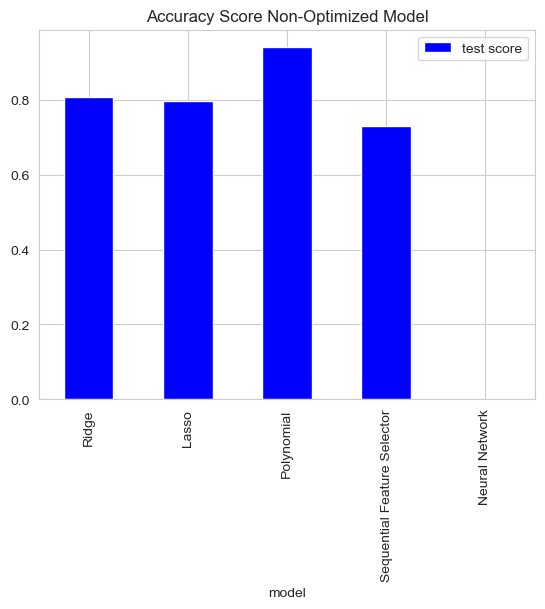

In [579]:
results_df = results_df.reset_index()
results_df.plot(kind='bar',
        x='model',
        y='test score',
        color='blue')

# set the title
plt.title('Accuracy Score Non-Optimized Model')

# show the plot
plt.show()

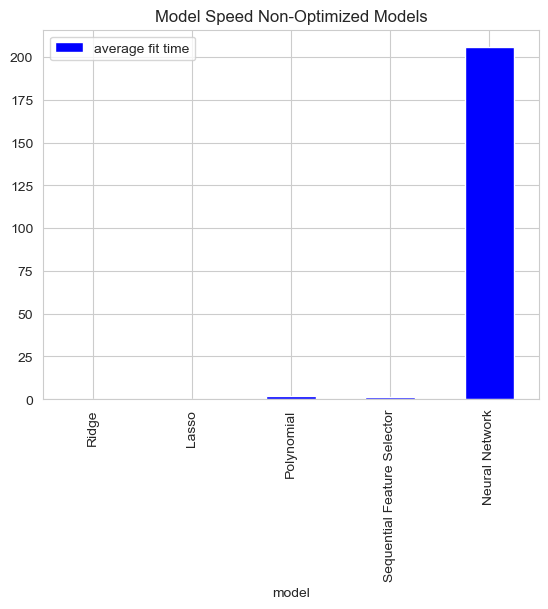

In [580]:
results_df.plot(kind='bar',
        x='model',
        y='average fit time',
        color='blue')

# set the title
plt.title('Model Speed Non-Optimized Models')

# show the plot
plt.show()

### Improving the Model

Models are improved and optimized with
- More feature engineering and exploration. 
- Hyperparameter tuning and grid search.

<b>Answer: </b> The first step is to determine the most important features of the model and reduce the dimentionality of the test data inorder to improve training performance.  Then using gridsearch, the optimum hyperparameters will be generated for each model and compared to the actual pervious results when the models were not optimized.

In [583]:
col_transformer2 = make_column_transformer((OrdinalEncoder(categories = [['Developing','Developed']]), ['Status']), remainder='passthrough')

transformed_data = col_transformer2.fit_transform(X_train)

# Get feature names
feature_names = col_transformer2.get_feature_names_out()

# Create a new DataFrame from the transformed data
df_transformed = pd.DataFrame(transformed_data, columns=feature_names)



df_transformed["life_expectancy"] = y_train["Life expectancy "]
print(df_transformed["life_expectancy"])
df_transformed.dropna(axis = 0, inplace=True)



df_transformed = df_transformed.filter(['ordinalencoder__Status', 'remainder__Adult Mortality',
       'remainder__infant deaths', 'remainder__Alcohol',
       'remainder__percentage expenditure', 'remainder__Hepatitis B',
       'remainder__Measles ', 'remainder__ BMI ',
       'remainder__under-five deaths ', 'remainder__ thinness 5-9 years',
       'remainder__Polio', 'remainder__Total expenditure',
       'remainder__Diphtheria ', 'remainder__ HIV/AIDS', 'remainder__GDP',
       'remainder__ thinness  1-19 years',
       'remainder__Income composition of resources',
       'remainder__Schooling','life_expectancy'], axis=1)

df_transformed = df_transformed.rename(columns={'ordinalencoder__Status': 'Status', 'remainder__Adult Mortality': 'Adult Mortality',
       'remainder__infant deaths': 'infant deaths', 'remainder__Alcohol': 'Alcohol',
       'remainder__percentage expenditure': 'percentage expenditure', 'remainder__Hepatitis B': 'Hepatitis B',
       'remainder__Measles ': 'Measles', 'remainder__ BMI ': 'BMI',
       'remainder__under-five deaths ': 'under-five deaths', 'remainder__ thinness 5-9 years': 'thinness 5-9 years',
       'remainder__Polio': 'Polio', 'remainder__Total expenditure': 'Total expenditure',
       'remainder__Diphtheria ': 'Diphtheria', 'remainder__ HIV/AIDS': 'HIV/AIDS', 'remainder__GDP': 'GDP',
       'remainder__ thinness  1-19 years': 'thinness  1-19 years',
       'remainder__Income composition of resources': 'Income composition of resources',
       'remainder__Schooling':'Schooling','life_expectancy': 'life_expectancy'})

df_transformed.corr()



0        NaN
1        NaN
2        NaN
3       59.5
4       59.2
        ... 
2051    74.7
2052    74.5
2053    74.2
2054    73.7
2055    81.1
Name: life_expectancy, Length: 2056, dtype: float64


,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,thinness 5-9 years,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,thinness 1-19 years,Income composition of resources,Schooling,life_expectancy
Status,1.000000,-0.312094,-0.114966,0.590250,0.448077,0.121431,-0.078081,0.312043,-0.118325,-0.363595,0.239019,0.297803,0.232236,-0.151946,0.460320,-0.363782,0.466119,0.489871,0.010223
Adult Mortality,-0.312094,1.000000,0.083294,-0.204711,-0.247959,-0.087814,0.033974,-0.366579,0.101003,0.288424,-0.281733,-0.142655,-0.285959,0.551193,-0.292286,0.288711,-0.450590,-0.450453,-0.026867
infant deaths,-0.114966,0.083294,1.000000,-0.135534,-0.085925,-0.137842,0.533543,-0.225005,0.996822,0.465486,-0.160785,-0.139635,-0.176368,0.022940,-0.102918,0.461678,-0.128322,-0.191829,0.049960
Alcohol,0.590250,-0.204711,-0.135534,1.000000,0.347730,0.098897,-0.064617,0.366894,-0.136431,-0.429977,0.243491,0.294783,0.241717,-0.074936,0.335881,-0.437990,0.457611,0.533196,-0.000422
percentage expenditure,0.448077,-0.247959,-0.085925,0.347730,1.000000,0.030501,-0.059800,0.243455,-0.088560,-0.258004,0.157813,0.203253,0.157150,-0.101006,0.905937,-0.256073,0.381063,0.384760,-0.018364
Hepatitis B,0.121431,-0.087814,-0.137842,0.098897,0.030501,1.000000,-0.065539,0.120006,-0.142772,-0.067272,0.397202,0.050362,0.461576,-0.020429,0.061367,-0.065043,0.105584,0.119746,-0.018731
Measles,-0.078081,0.033974,0.533543,-0.064617,-0.059800,-0.065539,1.000000,-0.169246,0.538901,0.247562,-0.124990,-0.097081,-0.135434,0.016153,-0.071889,0.246402,-0.107837,-0.132007,0.059818
BMI,0.312043,-0.366579,-0.225005,0.366894,0.243455,0.120006,-0.169246,1.000000,-0.235669,-0.543691,0.266775,0.250086,0.262236,-0.248639,0.283785,-0.535192,0.479263,0.507394,0.004292
under-five deaths,-0.118325,0.101003,0.996822,-0.136431,-0.088560,-0.142772,0.538901,-0.235669,1.000000,0.465005,-0.178283,-0.142020,-0.197756,0.036141,-0.106583,0.463012,-0.145012,-0.208205,0.051501
thinness 5-9 years,-0.363595,0.288424,0.465486,-0.429977,-0.258004,-0.067272,0.247562,-0.543691,0.465005,1.000000,-0.198210,-0.286292,-0.202666,0.213874,-0.282665,0.934598,-0.419321,-0.443222,0.060676


Below is a graph of the correlation matrix showing how each important feature corresponds to life expectancy

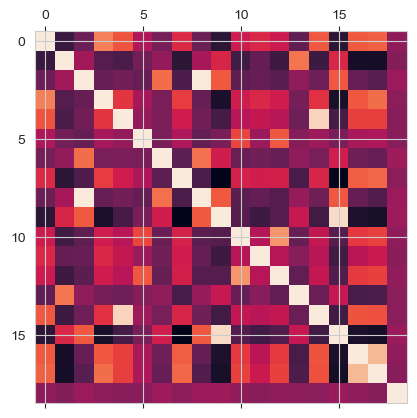

In [585]:
plt.matshow(df_transformed.corr())
plt.show()

In [586]:
df_transformed.head()

,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,thinness 5-9 years,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,thinness 1-19 years,Income composition of resources,Schooling,life_expectancy
3,0.0,68.0,1.0,9.33,0.000000,99.0,107.0,3.8,2.0,1.0,99.0,7.20,99.0,0.1,1766.947595,1.5,0.677,12.3,59.5
4,1.0,83.0,2.0,12.26,228.354302,82.0,67.0,58.8,2.0,0.5,98.0,7.25,98.0,0.1,1719.535410,0.6,0.828,15.7,59.2
5,0.0,73.0,0.0,1.93,266.769612,99.0,0.0,6.1,0.0,5.9,99.0,3.64,99.0,0.1,2722.138900,6.0,0.810,14.4,58.8
6,0.0,251.0,2.0,0.17,56.989525,83.0,1.0,21.1,2.0,7.0,84.0,3.82,83.0,0.1,778.545420,7.2,0.465,10.3,58.6
7,0.0,93.0,3.0,12.20,5451.701225,35.0,36.0,57.5,4.0,0.6,98.0,1.60,98.0,0.1,34879.726330,0.6,0.860,15.5,58.1


Using Permutation Importance, the most critical features that the baseline model uses for predictions are shown below

In [588]:
#df_transformed = df_transformed.drop(columns=['life_expectancy'])
columns = df_transformed.select_dtypes(exclude = object).columns.tolist()


In [589]:
def create_scatterplot(x_axis, column_name):
    
    # 1- set figure size
    plt.figure(figsize=(15, 20))

    # 2- loop over services list to plot columns
    for index, col in enumerate(column_name):
        plt.subplot((len(column_name) + 1) // 2, 2, index + 1) # create sub-plot
    
        sns.scatterplot(x = x_axis, y = col, data = df_transformed)
        
        plt.title(col) # set title to each plot
        plt.xlabel("") # replace x label with empty string
        plt.ylabel("") # replace y label with empty string

    # 3- set layout between two plots
    plt.tight_layout(pad = 2)

    plt.show()

In [591]:
df_transformed.head()

,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,thinness 5-9 years,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,thinness 1-19 years,Income composition of resources,Schooling,life_expectancy
3,0.0,68.0,1.0,9.33,0.000000,99.0,107.0,3.8,2.0,1.0,99.0,7.20,99.0,0.1,1766.947595,1.5,0.677,12.3,59.5
4,1.0,83.0,2.0,12.26,228.354302,82.0,67.0,58.8,2.0,0.5,98.0,7.25,98.0,0.1,1719.535410,0.6,0.828,15.7,59.2
5,0.0,73.0,0.0,1.93,266.769612,99.0,0.0,6.1,0.0,5.9,99.0,3.64,99.0,0.1,2722.138900,6.0,0.810,14.4,58.8
6,0.0,251.0,2.0,0.17,56.989525,83.0,1.0,21.1,2.0,7.0,84.0,3.82,83.0,0.1,778.545420,7.2,0.465,10.3,58.6
7,0.0,93.0,3.0,12.20,5451.701225,35.0,36.0,57.5,4.0,0.6,98.0,1.60,98.0,0.1,34879.726330,0.6,0.860,15.5,58.1


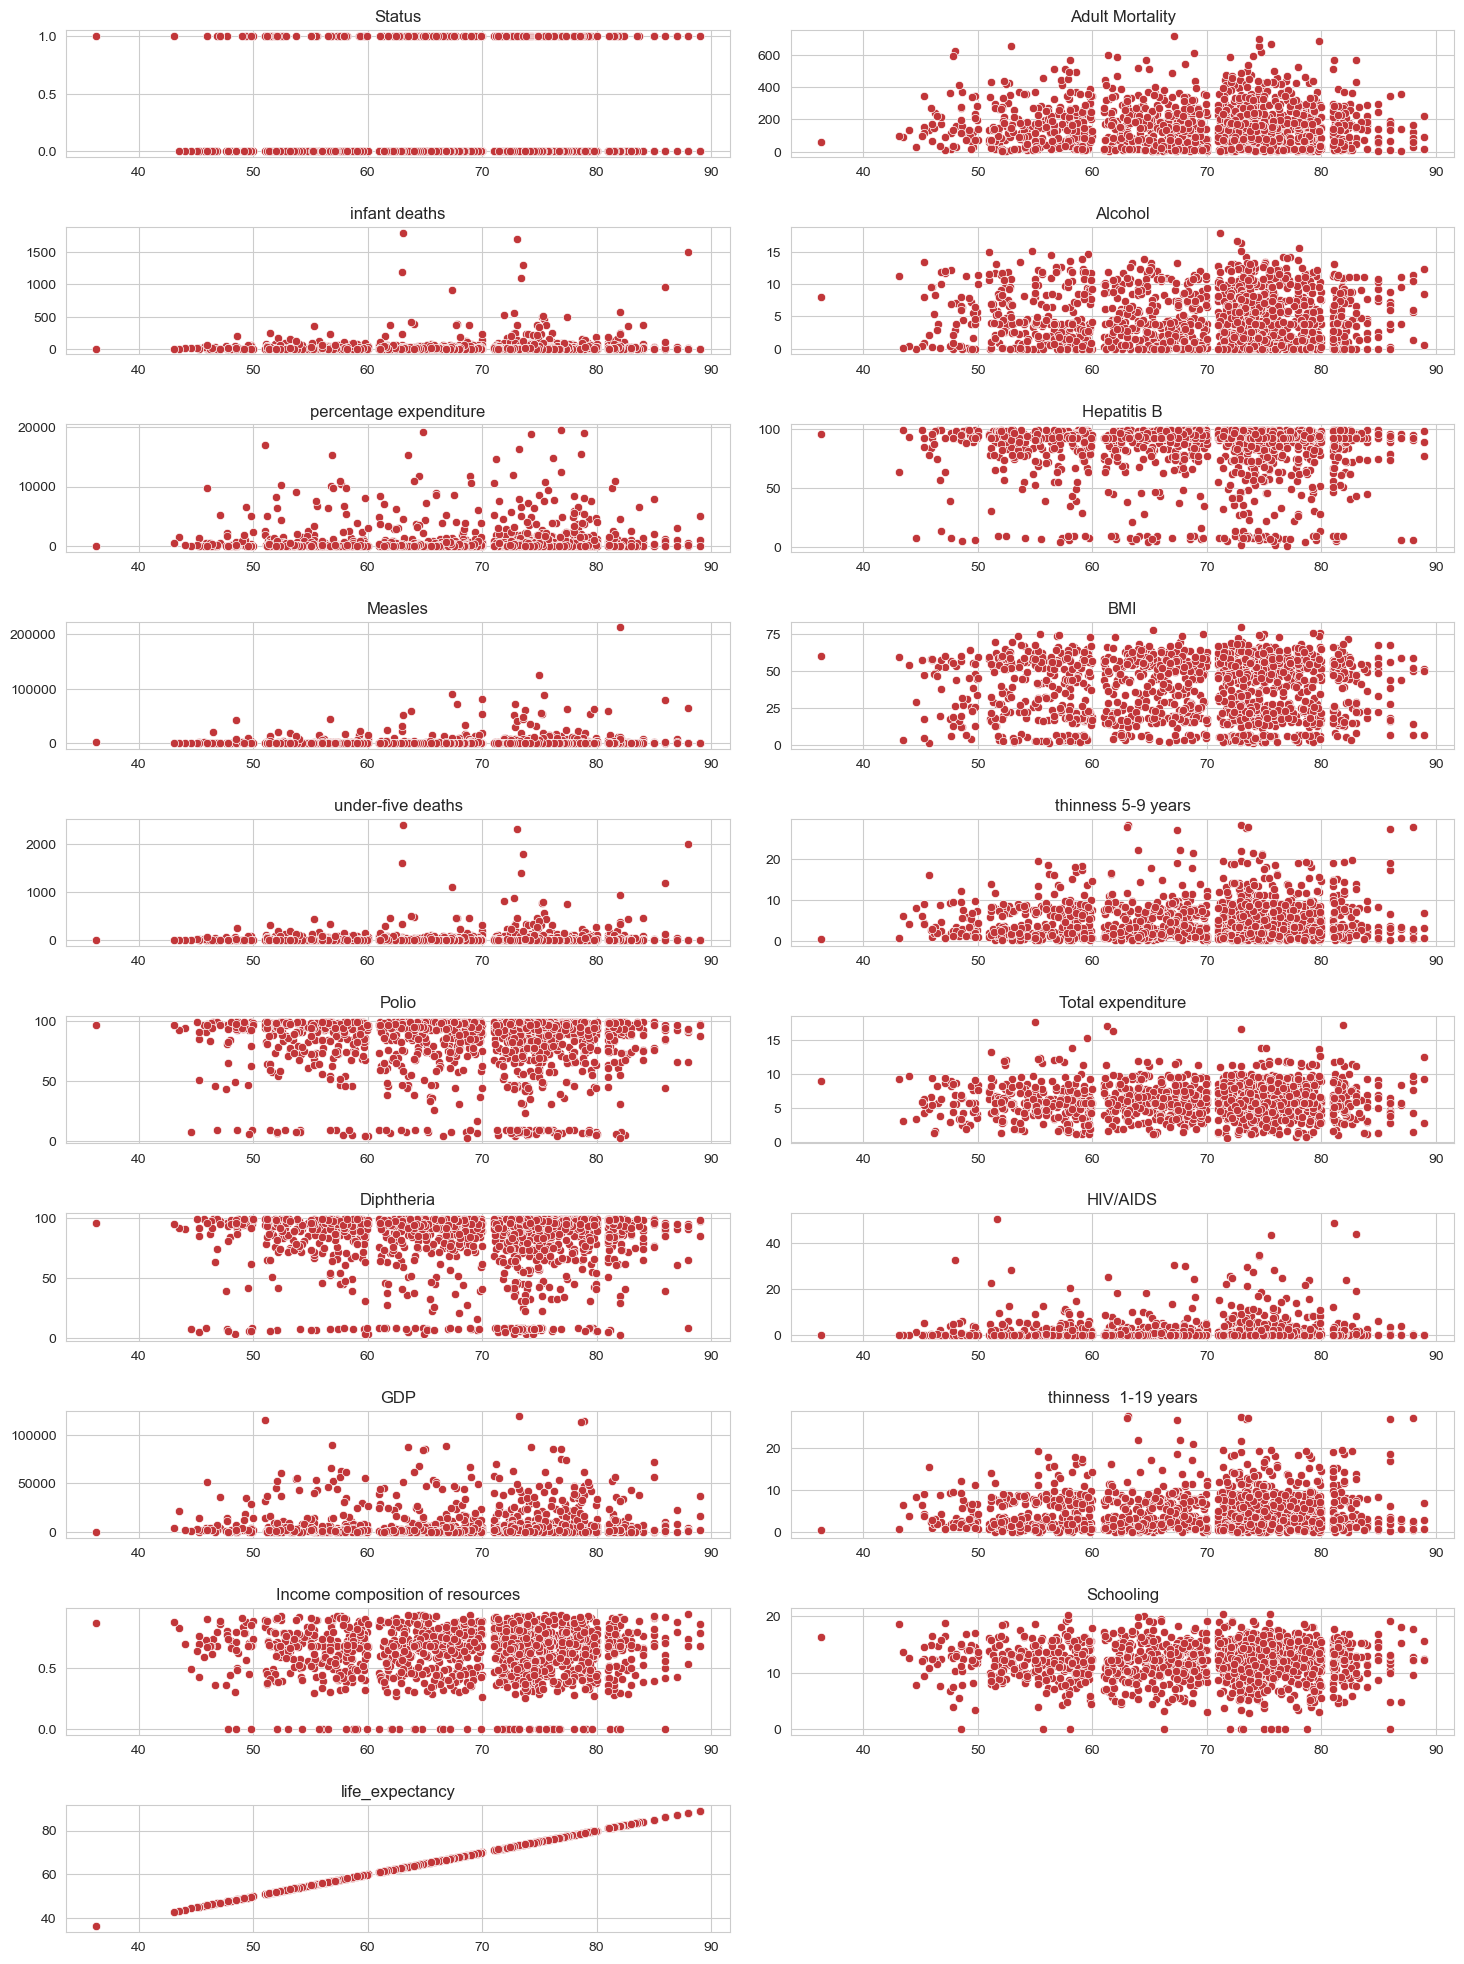

In [592]:
create_scatterplot("life_expectancy", columns) 

In [593]:
r = permutation_importance(baseline, X_train, y_train,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train.columns[i]:<7} "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

under-five deaths  3.350 +/- 0.091
infant deaths 3.231 +/- 0.080
Adult Mortality 0.142 +/- 0.004
 HIV/AIDS 0.117 +/- 0.004
Schooling 0.100 +/- 0.004
Income composition of resources 0.030 +/- 0.002
 BMI    0.024 +/- 0.002
Diphtheria  0.015 +/- 0.002
Polio   0.012 +/- 0.001
Status  0.010 +/- 0.001
GDP     0.008 +/- 0.001
Hepatitis B 0.003 +/- 0.001
 thinness  1-19 years 0.002 +/- 0.001
Measles  0.001 +/- 0.000


Below each model is optimized using Grid Search and the results will be later compared to baseline model and non-optimized models

In [596]:
ridge_param_grid = {
    'ridge__alpha': [0.000001, 0.0000001, 0.00000001, 0.000000001, 0.0000000001, 0.0000000001, 0.00000000001]
    
}

In [597]:
start_time = time.time()
ridge_grid = GridSearchCV(ridge, param_grid=ridge_param_grid).fit(X_train,y_train)
end_time = time.time()

fit_time_ridge = end_time - start_time
average_fit_time[0] = fit_time_log_reg

ridge_train = ridge_grid.score(X_train,y_train)
ridge_test = ridge_grid.score(X_test,y_test)
train_score[0] = ridge_train
test_score[0] =  ridge_test

print("Best Parameters:", ridge_grid.best_params_)

Best Parameters: {'ridge__alpha': 1e-06}


In [598]:
alpha_range = [0.0001, 0.00001]

lasso_param_grid = {
    'lasso__alpha': alpha_range,
    'lasso__max_iter' : [100000]
}

In [599]:
start_time = time.time()
lasso_grid = GridSearchCV(lasso, param_grid=lasso_param_grid).fit(X_train,y_train)
end_time = time.time()

fit_time_lasso_grid = end_time - start_time
average_fit_time[1] = fit_time_lasso_grid

lasso_acc_train = lasso_grid.score(X_train,y_train)
lasso_acc_test = lasso_grid.score(X_test,y_test)
train_score[1] = lasso_acc_train
test_score[1] =  lasso_acc_test

print("Best Parameters:", lasso_grid.best_params_)

Best Parameters: {'lasso__alpha': 0.0001, 'lasso__max_iter': 100000}


In [600]:
poly_param_grid = {'poly__degree': [2,3], 'poly__include_bias': [True, False]}

In [601]:
start_time = time.time()
poly_grid = GridSearchCV(poly, param_grid=poly_param_grid).fit(X_train,y_train)
end_time = time.time()

fit_time_poly_grid = end_time - start_time
average_fit_time[2] = fit_time_poly_grid

poly_acc_train = poly_grid.score(X_train,y_train)
poly_acc_test = poly_grid.score(X_test,y_test)
train_score[2] = poly_acc_train
test_score[2] =  poly_acc_test

print("Best Parameters:", poly_grid.best_params_)

Best Parameters: {'poly__degree': 2, 'poly__include_bias': False}


In [602]:
sfs_param_grid = [{
    'column_selector__cv' : [4,5], 'column_selector__n_features_to_select': [7,8]
}]

In [603]:
start_time = time.time()
sfs_grid = GridSearchCV(sfs, param_grid=sfs_param_grid).fit(X_train,y_train)
end_time = time.time()

fit_time_sfs_grid = end_time - start_time
average_fit_time[3] = fit_time_sfs_grid

sfs_acc_train = sfs_grid.score(X_train,y_train)
sfs_acc_test = sfs_grid.score(X_test,y_test)
train_score[3] = sfs_acc_train
test_score[3] =  sfs_acc_test
print("Best Parameters:", sfs_grid.best_params_)

Best Parameters: {'column_selector__cv': 4, 'column_selector__n_features_to_select': 8}


In [ ]:
res_dict = {'model': ['Ridge', 'Lasso','Polynomial','Sequential Feature Selector','Neural Network'],
           'train score': train_score,
           'test score': test_score,
           'average fit time':average_fit_time}
results_df = pd.DataFrame(res_dict).set_index('model')

In [ ]:
results_df

In [ ]:
results_df = results_df.reset_index()
results_df.plot(kind='bar',
        x='model',
        y='average fit time',
        color='green')

# set the title
plt.title('Speed Score Optimized Models')

# show the plot
plt.show()

In [ ]:
results_df.plot(kind='bar',
        x='model',
        y='test score',
        color='green')

# set the title
plt.title('Accuracy Score Optimized Models')

# show the plot
plt.show()